In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set()

## Prepare Data

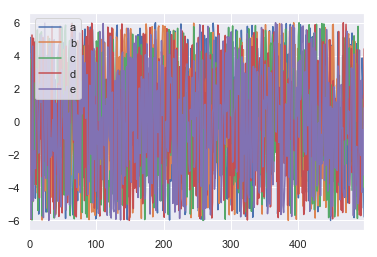

In [2]:
size_d = 500 # sample size
var_dim = 5  # dimension of variable.

x = np.array([list(np.random.permutation(np.linspace(-6, 6, size_d))) for _ in range(var_dim)]).T

df_x = pd.DataFrame(data=x, columns=['a', 'b', 'c', 'd', 'e'])
df_x.plot()
plt.show()

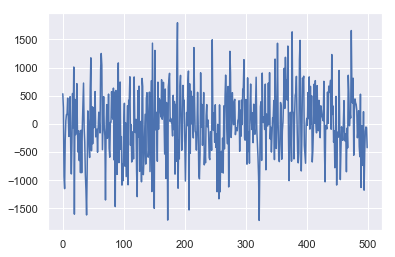

In [3]:
def obs_process(x):
    return (5*(x+3)*x*(x-3)).sum()
y_true = np.array([obs_process(_) for _ in df_x.values])
sns.lineplot(x=range(len(y_true)), y=y_true)

In [4]:
# Prepare test data.
np.random.seed(0)
y_noise = y_true + np.random.randn(size_d) * 50.0
size_p = 100
new_x_idx = np.random.permutation(df_x.index)
new_x_idx = new_x_idx[:size_p]
new_x_idx.sort()
df_new_x = df_x.loc[new_x_idx, :]
new_x = df_new_x.values
new_y_true = np.array([obs_process(_) for _ in df_new_x.values])

In [5]:
df_x.loc[:, 'y_true'] = y_true
df_x.loc[:, 'y_noise'] = y_noise
df_x['Predict_objective'] = np.nan
for i, idx in enumerate(new_x_idx):
    df_x.loc[idx, 'Predict_objective'] = new_y_true[i]

### This is our data
a,b,c,d and e is explanatory variables.  
y_true and y_noise is target variable.

In [6]:
df_x.head()

,a,b,c,d,e,y_true,y_noise,Predict_objective
0,4.148297,-1.815631,3.018036,3.234469,4.629259,535.018455,623.221072,NaN
1,5.110220,0.661323,3.787575,-4.244489,-3.282565,289.742370,309.750231,NaN
2,0.420842,1.983968,2.729459,-5.927856,-3.619238,-938.881421,-889.944522,NaN
3,-3.787575,-3.282565,-4.533066,-0.132265,-5.903808,-1149.400886,-1037.356226,NaN
4,2.993988,-0.036072,-5.975952,5.254509,-0.685371,-278.904121,-185.526221,NaN


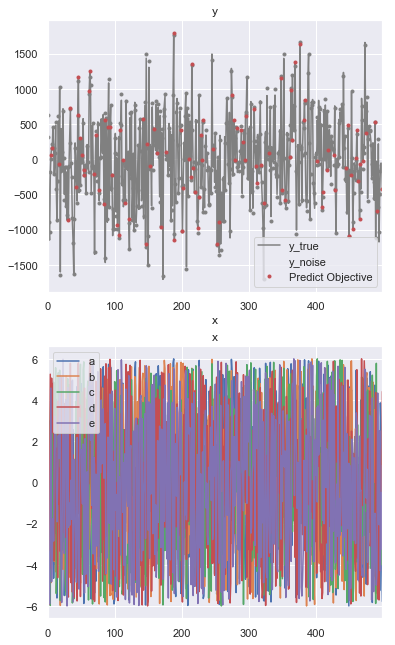

In [7]:
fig, ax = plt.subplots(2,1, figsize=(6,11))
df_x.loc[:,['a', 'b', 'c', 'd', 'e']].plot(ax=ax[1])
pd.DataFrame(
    {'x': df_x.index,
     'y_true': y_true}).plot(x='x', ax=ax[0], style='-', color='gray')
pd.DataFrame(
    {'x': df_x.index,
     'y_noise': y_noise}).plot(x='x', ax=ax[0], style='.', color='gray')
pd.DataFrame(
    {'x': df_new_x.index,
     'Predict Objective': new_y_true}).plot(x='x', ax=ax[0], style='.', color='r')
ax[0].set_title('y')
ax[1].set_title('x')
plt.show()

## Kernel regression with sampled teacher data

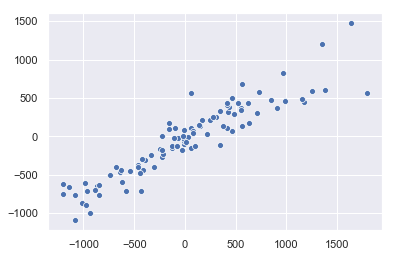

In [8]:
sample_size = 200  # Size of data to be used in learning.
beta = 0.1  # Kernel parameter
theta = 0.1  # Regularize parameter

# Gaussian Kernel
def kernel(x1, x2, beta=beta):
    return np.exp(- beta * np.linalg.norm(x1 - x2))

# Sampling teacher data.
df = df_x.sample(sample_size)
selected_x = df.loc[:, ['a', 'b', 'c', 'd', 'e']].values
selected_y = df.loc[:, 'y_noise'].values

# Gram matrix.
K = np.zeros((sample_size, sample_size))
for i in range(sample_size):
    for j in range(sample_size):
        K[i,j] = kernel(selected_x[i], selected_x[j])
        
# Compute psuede inverse matrix of the gram matrix.
K_pinv = np.linalg.pinv(K + theta*np.identity(sample_size))

# Compute weight of learned model of each data point.
alpha = selected_y*K_pinv

# Prediction
y_predict = np.zeros(size_p)
# Weight of new data of each data point. 
w_x = np.zeros((size_p, sample_size))
for i in range(size_p):
    for j in range(sample_size):
        w_x[i, j] = kernel(new_x[i, :], selected_x[j, :])  
# Prediction
for i in range(size_p):
    for j in range(sample_size):
        y_predict[i] += (alpha[:, j]@w_x[i,:])

sns.scatterplot(x=new_y_true, y=y_predict)
plt.show()

## Predict another data

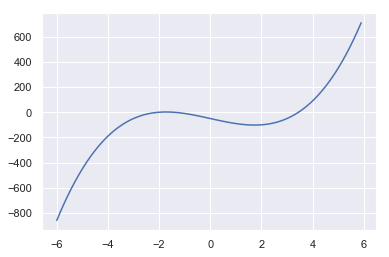

In [9]:
def myx2(x):
    return np.array([0.12783293, 0.169141  , x , 0.3474041 , 0.4787337 ])
x2 = np.array([myx2(_) for _ in np.arange(-6,6, 0.1)])
y_true2 = np.array([obs_process(_) for _ in x2])
sns.lineplot(x=np.arange(-6,6, 0.1), y=y_true2)
plt.show()

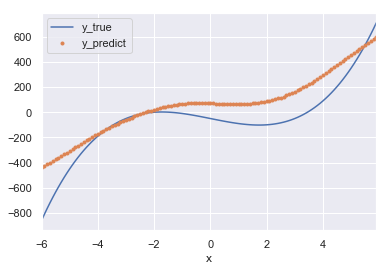

In [10]:
size_p2 = y_true2.shape[0]

# Prediction
y_predict2 = np.zeros(size_p2)
# Weight of new data of each data point. 
w_x = np.zeros((size_p2, sample_size))
for i in range(size_p2):
    for j in range(sample_size):
        w_x[i, j] = kernel(x2[i, :], selected_x[j, :])  
# Prediction
for i in range(size_p2):
    for j in range(sample_size):
        y_predict2[i] += (alpha[:, j]@w_x[i,:])

fig, ax = plt.subplots()
pd.DataFrame(
    {'x': [_[2] for _ in x2],
     'y_true': y_true2}).plot(x='x', ax=ax)
pd.DataFrame(
    {'x': [_[2] for _ in x2],
     'y_predict': y_predict2}).plot(x='x', style='.', ax=ax)
plt.show()